In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from denoise_rmt import (
    ImgNoiseCorruptor,
    denoise_mppca,
    plot_local_mppca,
    snr, psnr, ssim,
    average_snr, average_psnr, average_ssim
)

In [4]:
def plot_slices(slices, titles=None, cmap="gray", origin="lower"):
    """Function to display a row of image slices."""
    n_slices = len(slices)
    fig, axes = plt.subplots(1, n_slices, figsize=(3.5 * n_slices, 3.8))

    if len(slices) > 1:
        for i, slice_array in enumerate(slices):
            axes[i].imshow(slice_array, cmap=cmap, origin=origin, aspect="auto")
            if titles is not None:
                axes[i].set_title(titles[i])
            axes[i].grid(False)
    else:
        axes.imshow(slices[0], cmap=cmap, origin=origin)
        if titles is not None:
            axes.set_title(titles[0])
        axes.grid(False)

In [5]:
tumor_slice = np.load("sim_data/sample_tumor_img.npy")
tumor_slice.shape

(184, 132)

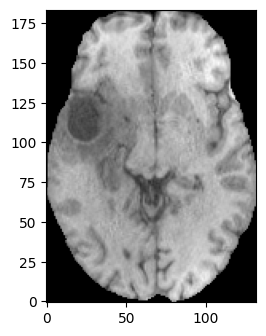

In [6]:
plot_slices([tumor_slice])

In [7]:
pad_tumor_slice = np.pad(tumor_slice, pad_width=5, mode="constant", constant_values=0)
pad_tumor_slice.shape

(194, 142)

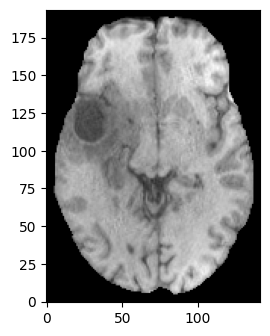

In [16]:
# Title: "Original brain slice"
plot_slices([pad_tumor_slice])

In [9]:
# Number of measurements (snapshots)
n_snapshots = 100

# RNG seed
seed = 1

# Noise parameters
sigma = 35  # Marchenko-Pastur sigma ~ noise standard deviation
rice_b = 2  # Rice distribution parameter

# Denoising parameters
window_size = 16  # 16x16 MPPCA window size


In [10]:
noise_corruptor = ImgNoiseCorruptor(original_img=pad_tumor_slice)

In [11]:
snapshots, fg_masks = noise_corruptor.generate_rician_noisy_displaced_imgs(
    n_snapshots=n_snapshots,
    rice_b=rice_b,
    sigma=sigma,
    seed=seed,
)

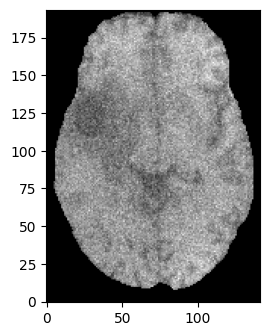

In [17]:
# Title: "Sample of corrupted image"
plot_slices([snapshots[0]])

In [13]:
denoised_snapshots = denoise_mppca(snapshots, sigma=sigma, window_size=window_size)

Denoising 100 snapshots of size 194x142 (sigma = 35).


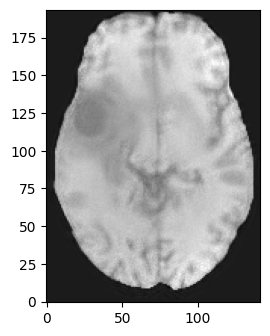

In [18]:
# Title: "Denoised image using MPPCA"
plot_slices(slices=[denoised_snapshots[0]])

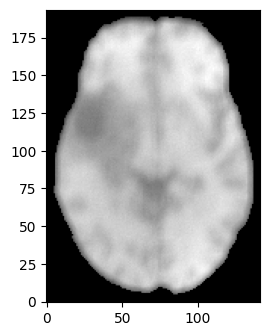

In [19]:
original_mask = pad_tumor_slice > 0.0
den_mean_img = original_mask * np.mean(snapshots, axis=0)

# Title: "Denoised snapshots by averaging"
plot_slices([den_mean_img])

In [17]:
ss_avg_snr = average_snr(ref_img=pad_tumor_slice, test_imgs=snapshots)
ss_avg_psnr = average_psnr(ref_img=pad_tumor_slice, test_imgs=snapshots)

print(f"Average SNR of snapshots using MPPCA: {ss_avg_snr}.")
print(f"SNR of image denoised by averaging: {ss_avg_psnr}.")

Average SNR of snapshots using MPPCA: 4.357015139513695.
SNR of image denoised by averaging: 9.994951880143695.


In [18]:
den_ss_avg_snr = average_snr(ref_img=pad_tumor_slice, test_imgs=denoised_snapshots)
den_means_snr = snr(ref_img=pad_tumor_slice, test_img=den_mean_img)

print(f"Average SNR of snapshots using MPPCA: {den_ss_avg_snr}.")
print(f"SNR of image denoised by averaging: {den_means_snr}.")

Average SNR of snapshots using MPPCA: 4.929535413057519.
SNR of image denoised by averaging: 6.366646869019334.


In [19]:
den_ss_avg_psnr = average_psnr(ref_img=pad_tumor_slice, test_imgs=denoised_snapshots)
den_means_psnr = psnr(ref_img=pad_tumor_slice, test_img=den_mean_img)

print(f"Average PSNR of snapshots using MPPCA: {den_ss_avg_psnr}.")
print(f"PSNR of image denoised by averaging: {den_means_psnr}.")

Average PSNR of snapshots using MPPCA: 10.567472153687522.
PSNR of image denoised by averaging: 12.004583609649336.


In [20]:
den_ss_avg_ssim = average_ssim(ref_img=pad_tumor_slice, test_imgs=denoised_snapshots)
den_means_ssim = ssim(pad_tumor_slice, den_mean_img, data_range=255)

print(f"Average SSIM of snapshots using MPPCA: {den_ss_avg_ssim}.")
print(f"SSIM of image denoised by averaging: {den_means_ssim}.")

Average SSIM of snapshots using MPPCA: 0.5001265042245087.
SSIM of image denoised by averaging: 0.6890719110465802.


In [21]:
local_window = snapshots[:,100:100+window_size,40:40+window_size]
local_X = np.reshape(local_window, (n_snapshots, window_size**2))

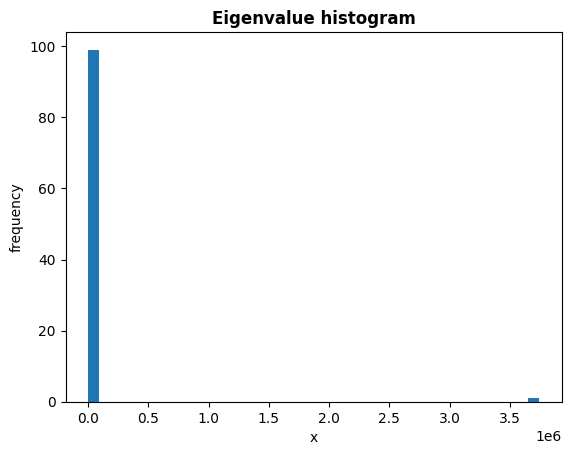

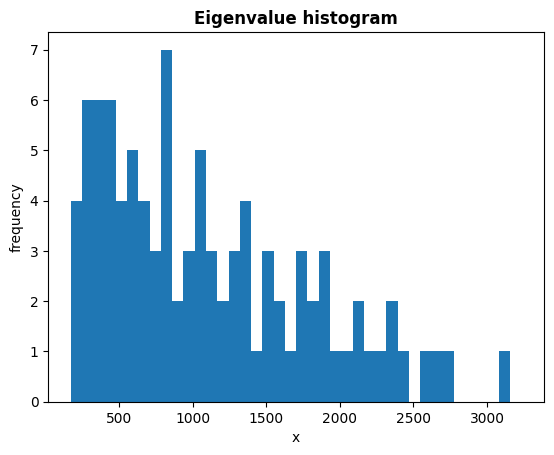

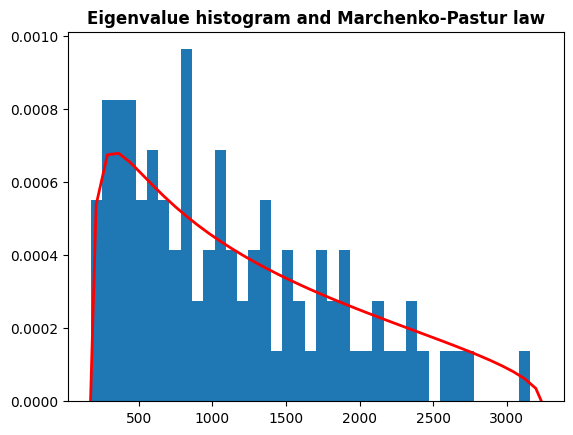

In [22]:
plot_local_mppca(local_X, sigma=sigma)